In [72]:
import statsmodels.formula.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse
% matplotlib inline

## Read in the data, set index, re-code categoricals

In [73]:
data = pd.read_csv("spotify_data.csv")
data.index.name = "id"
key_map = {0:"C", 1:"Csharp", 2:"D", 3:"Dsharp", 4:"E", 5:"F", 6:"Fsharp", 7:"G", 8:"Gsharp", 9:"A", 10:"Asharp", 11:"B"}
data.key = data.key.apply(lambda x: key_map[x])
data = pd.concat([data, pd.get_dummies(data["key"], prefix="key")], axis=1)
Y = data["popularity"]
data.drop(["Unnamed: 0", "key", "release_date", "song", "artist"], axis=1, inplace=True)
data.head()
feature_names = list(data.columns)
feature_names.remove("popularity")

## Run simple linear regression with every feature to see pvalues

In [127]:
simple_table = dict()
for feature in feature_names:
    fitted = sm.ols(formula="popularity ~ " + feature, data=data).fit()
    coeff = fitted.params[1]
    pvalue = fitted.pvalues[1]
    r2 = fitted.rsquared
    simple_table[feature] = [coeff, pvalue, round(r2, 4)]
    
    
simple_df = pd.DataFrame(data=simple_table).T
simple_df.columns = ["coeff", "pvalue", "r2"]
simple_df

,coeff,pvalue,r2
acousticness,-9.713727,4.685862e-42,0.0220
artist_followers,0.000004,7.981461e-223,0.1150
danceability,18.966368,1.681935e-40,0.0211
duration_ms,-0.000005,8.834781e-02,0.0003
energy,9.031304,4.592659e-22,0.0112
instrumentalness,-11.927539,2.789444e-29,0.0151
key_A,-1.995881,7.039827e-03,0.0009
key_Asharp,1.371000,1.490170e-01,0.0003
key_B,2.657466,2.948932e-03,0.0011
key_C,0.236437,7.313612e-01,0.0000


In [75]:
all_preds_table = pd.DataFrame(data=[fitted.params, fitted.pvalues]).T
all_preds_table.columns = ["coeff", "pvalue"]
all_preds_table

,coeff,pvalue
Intercept,51.954032,3.576070e-79
artist_followers,0.000003,6.886614e-167
acousticness,-4.967214,1.028130e-06
danceability,14.242834,3.684633e-18
duration_ms,-0.000010,1.407517e-04
energy,-10.906705,1.887625e-09
instrumentalness,-2.587740,1.449832e-02
liveness,-5.852998,7.386359e-06
loudness,1.038017,1.101211e-36
mode,-1.448762,2.987842e-03


In [76]:
pred_table = pd.DataFrame(data=dict(prediction=fitted.predict(data), popularity=data.popularity))

In [77]:
mse(pred_table.popularity, pred_table.prediction)

365.72229805853186

## Plot correlation coeffs vs popularity

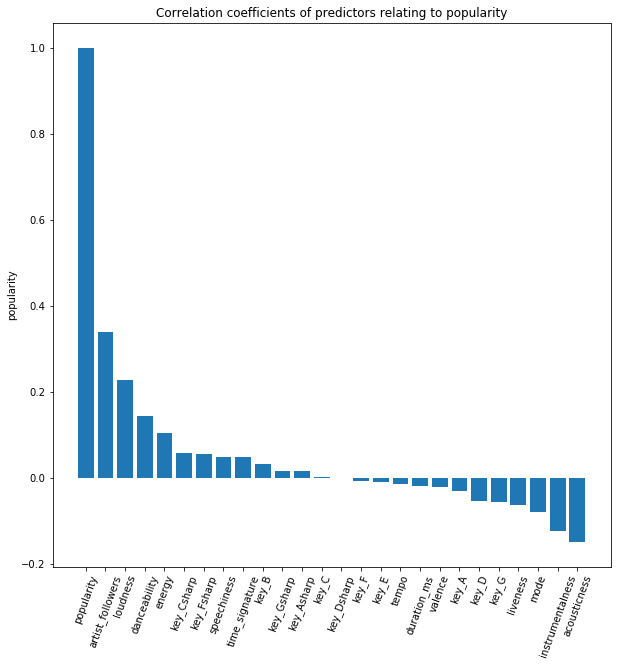

In [110]:
fig = plt.figure(figsize=(10, 10))
# plt.scatter(data.speechiness, data.popularity)
# plt.matshow(data.corr())
pop_corr = data.corr()["popularity"]
pop_corr = pop_corr.copy(deep=True)
pop_corr.sort_values(inplace=True, ascending=False)
plt.bar(range(len(pop_corr.index)), pop_corr.values)
xticks = plt.xticks(range(len(pop_corr.index)), pop_corr.index, rotation=70)
plt.ylabel("popularity")
t = plt.title("Correlation coefficients of predictors relating to popularity")
plt.savefig("figs/corr_bar.png")

## Fitting regression on top postive corr vars and top negative corr vars (individually)

In [79]:
tops = ["artist_followers", "loudness", "danceability", "energy", "key_Csharp"]
bottoms = ["acousticness", "instrumentalness", "mode", "liveness", "key_G"]

top_table = dict()
bot_table = dict()

# tops first
for t in tops:
    fitted = sm.ols(formula="popularity ~ " + t, data=data).fit()
    coeff, pval = fitted.params[1], fitted.pvalues[1]
    top_table[t] = [coeff, pval]
    
# now bottoms
for b in bottoms:
    fitted = sm.ols(formula="popularity ~ " + b, data=data).fit()
    coeff, pval = fitted.params[1], fitted.pvalues[1]
    bot_table[b] = [coeff, pval]
    
top_table = pd.DataFrame(data=top_table).T
top_table.columns = ["coeff", "pvalue"]
bot_table = pd.DataFrame(data=bot_table).T
bot_table.columns = ["coeff", "pvalue"]

In [80]:
top_table

,coeff,pvalue
artist_followers,0.000004,7.981461e-223
danceability,18.966368,1.681935e-40
energy,9.031304,4.592659e-22
key_Csharp,4.525527,5.162713e-08
loudness,1.077258,5.044759e-98


In [81]:
bot_table
pd.concat([top_table, bot_table])

,coeff,pvalue
artist_followers,0.000004,7.981461e-223
danceability,18.966368,1.681935e-40
energy,9.031304,4.592659e-22
key_Csharp,4.525527,5.162713e-08
loudness,1.077258,5.044759e-98
acousticness,-9.713727,4.685862e-42
instrumentalness,-11.927539,2.789444e-29
key_G,-3.543565,7.584568e-07
liveness,-7.913839,8.077932e-09
mode,-3.664818,5.461137e-13


## Running a multiple linear regression for each partition

In [132]:
# tops 
fitted = sm.ols(formula="popularity ~ " + "+".join(tops), data=data).fit()
tops_multiple_regression = pd.DataFrame(data=[fitted.params, fitted.pvalues]).T
tops_multiple_regression.columns = ["coeff", "pvalue"]
print fitted.fvalue

# bottoms 
fitted = sm.ols(formula="popularity ~ " + "+".join(bottoms), data=data).fit()
fitted.summary()
bottom_multiple_regression = pd.DataFrame(data=[fitted.params, fitted.pvalues]).T
bottom_multiple_regression.columns = ["coeff", "pvalue"]
multiple_regression_parts = pd.concat([tops_multiple_regression, bottom_multiple_regression]).drop("Intercept")

multiple_regression_parts

318.854824878


,coeff,pvalue
artist_followers,0.000003,6.870911e-176
loudness,1.236665,2.649535e-58
danceability,12.331949,3.108602e-20
energy,-11.872530,1.647739e-18
key_Csharp,2.112484,5.868507e-03
acousticness,-8.650842,2.140468e-33
instrumentalness,-10.795340,1.240683e-24
mode,-2.907516,8.362286e-09
liveness,-9.493790,1.904590e-12
key_G,-2.966781,2.537528e-05


## Explaining energy variable negative slope
The below corrrelation matrix shows the corelation between energy and loudness to be quite high at a value around .8. This reveals a tendency for loudness to increase as energy increases in a given song. So if the multiple linear regression is correct, loudness affects popularity of a song directly, so energy acts as a surrogate for loudness since in the simple linear regression it appeared that energy directly affects popularity. 

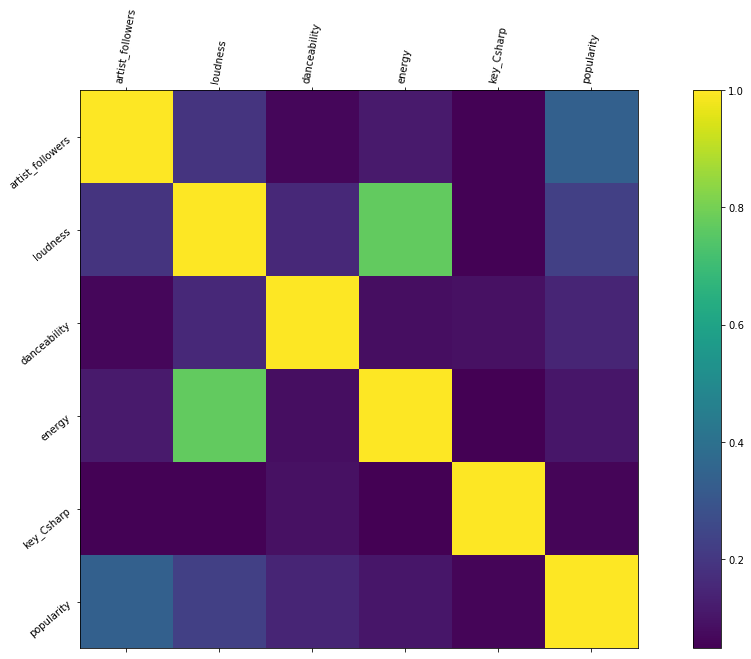

In [117]:
top_5_data = data[['artist_followers', 'loudness', 'danceability', 'energy', 'key_Csharp', 'popularity']]
bot_5_data = data[['acousticness', 'instrumentalness', 'mode', 'liveness', 'key_G', 'popularity']]

plt.figure(figsize=(20, 10))
cmax = plt.matshow(top_5_data.corr(), fignum=1, )
plt.colorbar(cmax)
xticks = plt.xticks(range(len(top_5_data.columns)), top_5_data.columns, rotation=80)
yticks = plt.yticks(range(len(top_5_data.columns)), top_5_data.columns, rotation=40)
plt.savefig("figs/top_5_corr_matrix.png")

# for the bottom 
# plt.figure(figsize=(20, 10))
# cmax = plt.matshow(bot_5_data.corr(), fignum=2)
# plt.colorbar(cmax)
# xticks = plt.xticks(range(len(bot_5_data.columns)), bot_5_data.columns, rotation=80)
# yticks = plt.yticks(range(len(bot_5_data.columns)), bot_5_data.columns, rotation=40)
# plt.savefig("figs/bot_5_corr_matrix.png")


In [118]:
top_5_data.corr()

,artist_followers,loudness,danceability,energy,key_Csharp,popularity
artist_followers,1.000000,0.191707,0.064928,0.115616,0.054408,0.339101
loudness,0.191707,1.000000,0.155469,0.769402,0.052415,0.227441
danceability,0.064928,0.155469,1.000000,0.083335,0.090226,0.145362
energy,0.115616,0.769402,0.083335,1.000000,0.047370,0.105623
key_Csharp,0.054408,0.052415,0.090226,0.047370,1.000000,0.059675
popularity,0.339101,0.227441,0.145362,0.105623,0.059675,1.000000
